In [86]:
import itertools
import numpy as np
import pandas as pd
import ds_charts as ds
from datetime import datetime
import matplotlib.pyplot as plt
from seaborn import distplot,heatmap
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler,  KBinsDiscretizer

In [87]:
#register_matplotlib_converters()
#Definição variáveis iniciais
file = 'XAI - Limpo_dummified.csv'
name = 'XAI - Limpo'
tc = 'surgycal margin'
data = pd.read_csv(file,index_col=tc,na_values='',sep=',', decimal='.')
df = pd.DataFrame(data)
data.shape
data.dtypes

Age.at.MRI                                     float64
Prostate.volume                                  int64
PSA.value.at.MRI                               float64
Index.lesion.size                                int64
Capsular.contact.lenght_TLC                      int64
Smooth.capsular.bulging                          int64
Capsular.disruption                              int64
Unsharp.margin                                   int64
Irregular.contour                                int64
Black.estrition.periprostatic.fat                int64
Retoprostatic.angle.obliteration                 int64
Measurable.ECE                                   int64
ECE.in.prostatectomy.specimen_gold.standard      int64
Gleason.score                                    int64
regra                                            int64
Index.lesion.PIRADS.V2_3                       float64
Index.lesion.PIRADS.V2_4                       float64
Index.lesion.PIRADS.V2_5                       float64
dtype: obj

In [13]:
#Tipos de variável
def get_variable_types(df):
    NR_SYMBOLS = 10
    variable_types = {'binary': [], 'numeric': [], 'date': [], 'symbolic': []}
    for c in df.columns:
        mv = df[c].isna().sum()
        uniques = df[c].unique()
        if mv == 0:
            if len(uniques) == 2:
                variable_types['binary'].append(c)
                df[c].astype('bool')
            elif df[c].dtype == 'datetime64':
                variable_types['date'].append(c)
            elif len(uniques) < NR_SYMBOLS:
                df[c].astype('category')
                variable_types['symbolic'].append(c)
            else:
                variable_types['numeric'].append(c)
        else:
            uniques = [v for v in uniques if not np.isnan(v)]
            values = [v for v in uniques if isinstance(v,str)]
            if len(uniques) == 2:
                variable_types['binary'].append(c)
            elif len(values) == len(uniques):
                df[c].astype('category')
                variable_types['symbolic'].append(c)
            else:
                values = [v for v in uniques if isinstance(v, datetime)]
                if len(values) == len(uniques):
                    variable_types['date'].append(c)
                else:
                    variable_types['numeric'].append(c)
    return variable_types

{'binary': ['Smooth.capsular.bulging', 'Capsular.disruption', 'Unsharp.margin', 'Irregular.contour', 'Black.estrition.periprostatic.fat', 'Retoprostatic.angle.obliteration', 'Measurable.ECE', 'ECE.in.prostatectomy.specimen_gold.standard', 'Gleason.score', 'regra', 'Index.lesion.PIRADS.V2_3', 'Index.lesion.PIRADS.V2_4', 'Index.lesion.PIRADS.V2_5'], 'numeric': ['Age.at.MRI', 'Prostate.volume', 'PSA.value.at.MRI', 'Index.lesion.size', 'Capsular.contact.lenght_TLC'], 'date': [], 'symbolic': []}


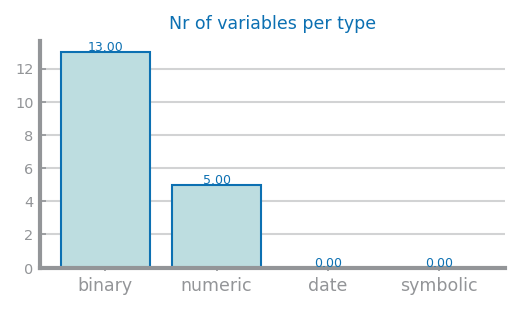

In [88]:
#Cálculo das variáveis
variable_types = get_variable_types(data)
print(variable_types)
counts = {}
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])
plt.figure(figsize=(4,2))
ds.bar_chart(list(counts.keys()), list(counts.values()), title='Nr of variables per type')
#plt.savefig('Images/variable_types.png')
plt.show()

#Tipos das variáveis
binary_vars = variable_types['binary']
numeric_vars = variable_types['numeric']
symbolic_vars = variable_types['symbolic']

df_nr = data[numeric_vars]
df_sb = data[symbolic_vars]
df_bool = data[binary_vars]


In [69]:
#Dummification das variáveis simbólicas  - 'Index.lesion.PIRADS.V2'
def dummify(df, vars_to_dummify):
    other_vars = [c for c in df.columns if not c in vars_to_dummify]
    print(vars_to_dummify,other_vars)
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    X = df[vars_to_dummify]
    encoder.fit(X)
    new_vars = encoder.get_feature_names(vars_to_dummify)
    trans_X = encoder.transform(X)
    dummy = pd.DataFrame(trans_X, columns=new_vars, index=X.index)
    final_df = pd.concat([df[other_vars], dummy], axis=1)
    
    return final_df

dF = dummify(data, symbolic_vars)
dF.to_csv(f'{name}_dummified.csv', index='surgycal margin')

[] ['Age.at.MRI', 'Prostate.volume', 'PSA.value.at.MRI', 'Index.lesion.size', 'Capsular.contact.lenght_TLC', 'Smooth.capsular.bulging', 'Capsular.disruption', 'Unsharp.margin', 'Irregular.contour', 'Black.estrition.periprostatic.fat', 'Retoprostatic.angle.obliteration', 'Measurable.ECE', 'ECE.in.prostatectomy.specimen_gold.standard', 'Gleason.score', 'regra', 'Index.lesion.PIRADS.V2_3', 'Index.lesion.PIRADS.V2_4', 'Index.lesion.PIRADS.V2_5']


       Age.at.MRI  Prostate.volume  PSA.value.at.MRI  Index.lesion.size  \
count  115.000000       115.000000        115.000000         115.000000   
mean     0.533982         0.195518          0.253679           0.345894   
std      0.215120         0.167529          0.192624           0.211052   
min      0.000000         0.000000          0.000000           0.000000   
25%      0.402961         0.084615          0.125789           0.185185   
50%      0.552632         0.169231          0.200000           0.296296   
75%      0.689145         0.223077          0.330000           0.462963   
max      1.000000         1.000000          1.000000           1.000000   

       Capsular.contact.lenght_TLC  Smooth.capsular.bulging  \
count                   115.000000               115.000000   
mean                      0.320870                 0.600000   
std                       0.218947                 0.492042   
min                       0.000000                 0.000000   
25%      

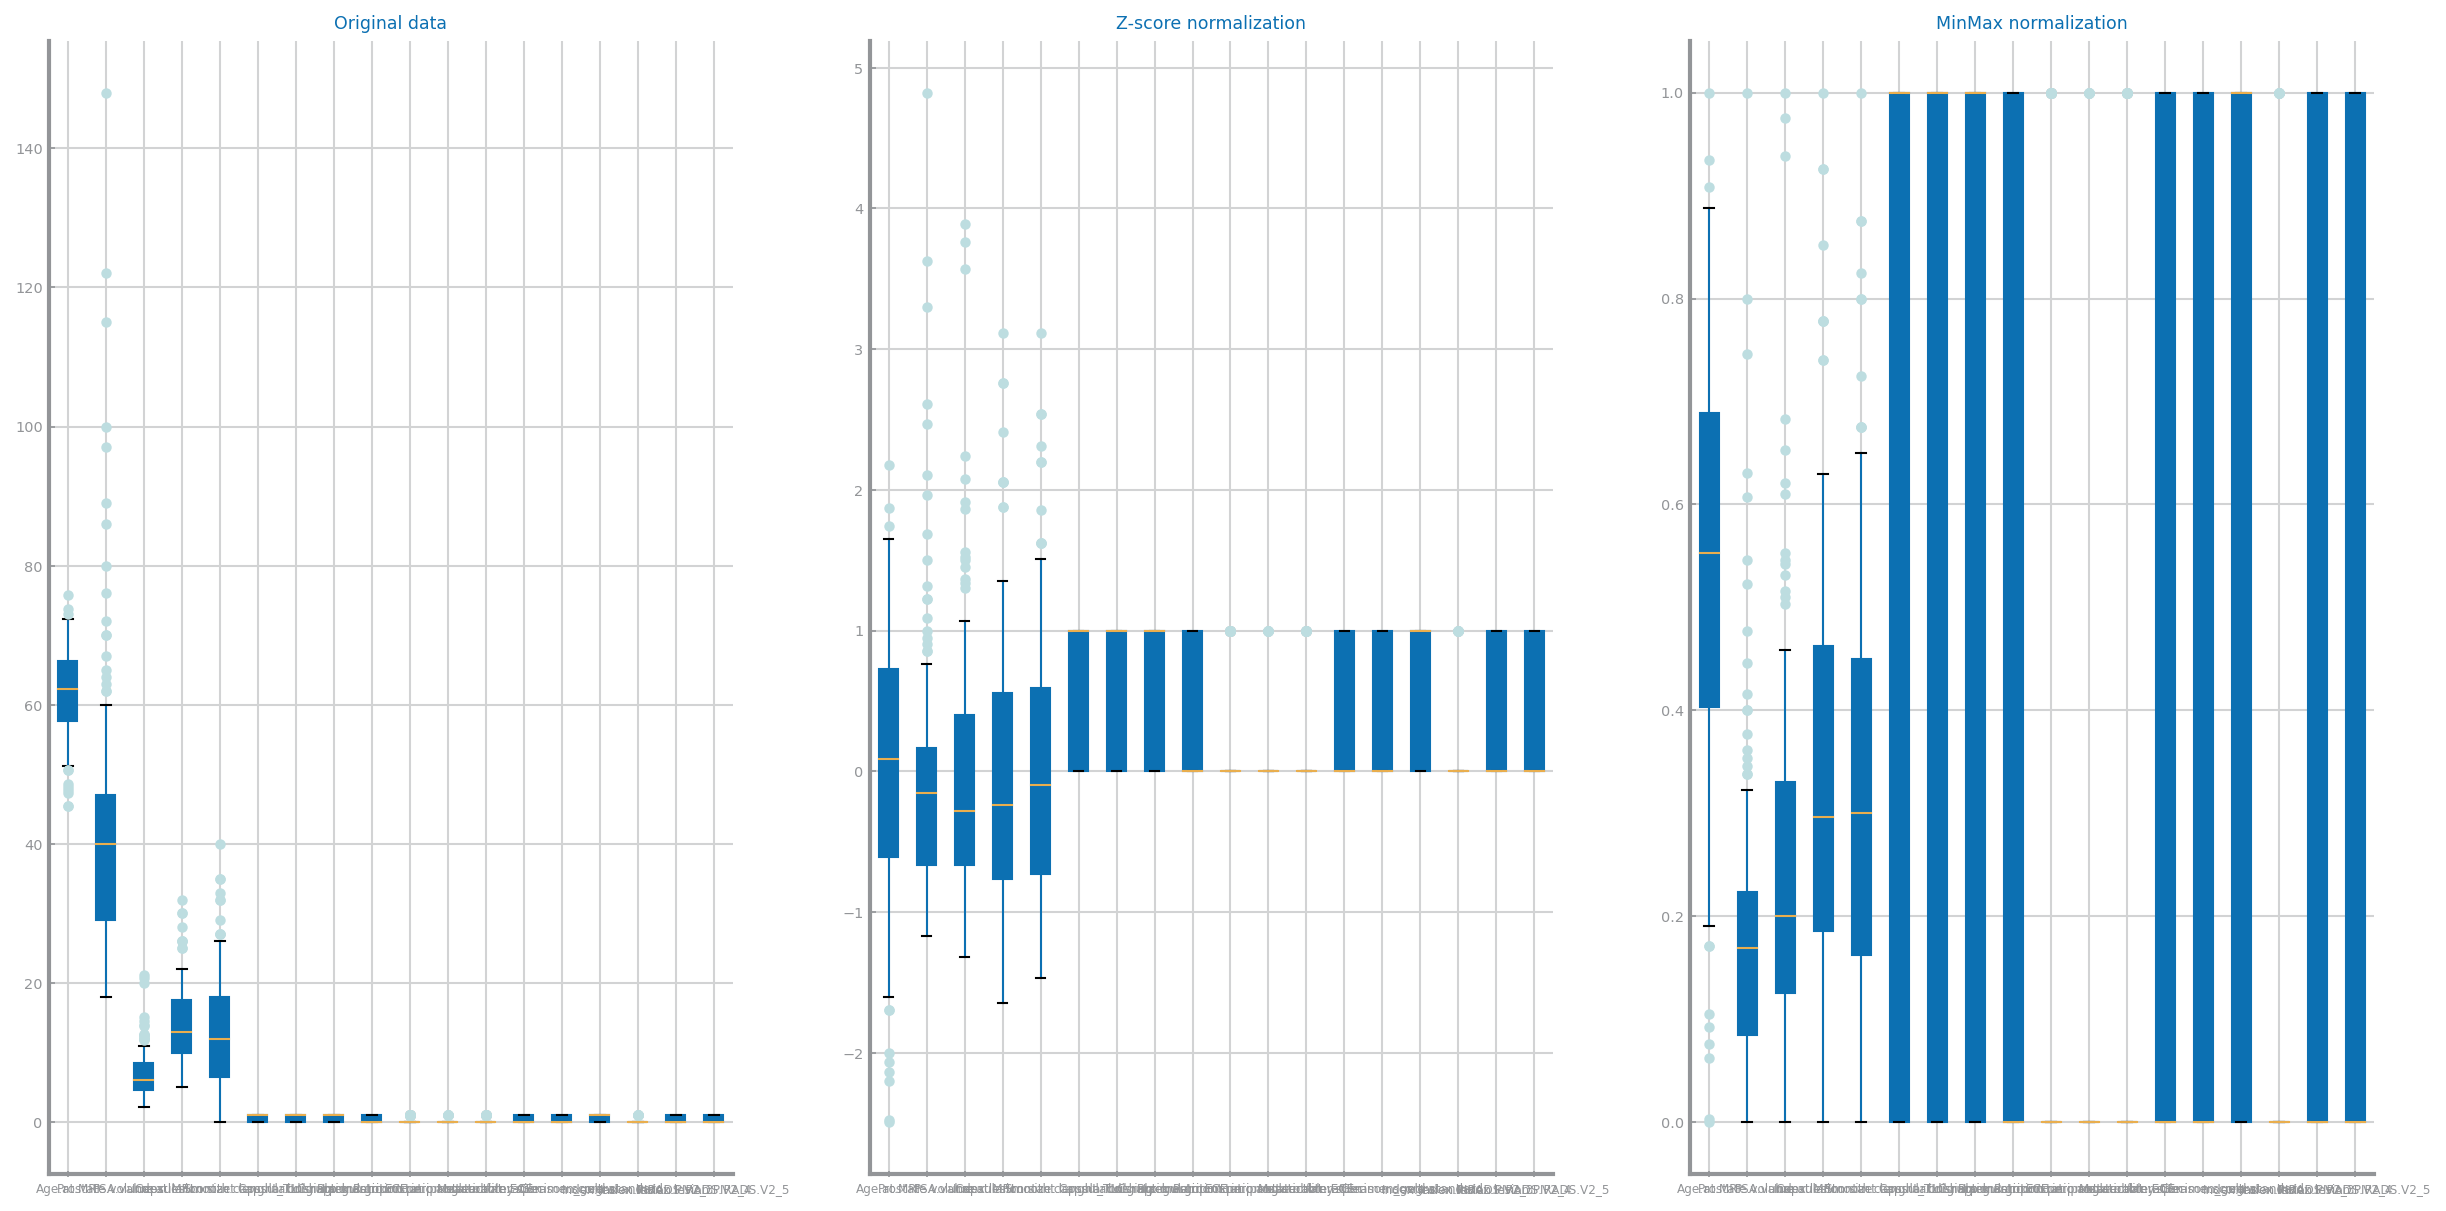

In [72]:
#Scalling 

#Z-score transformation
transfS = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
tmpS = pd.DataFrame(transfS.transform(df_nr), index=data.index, columns= numeric_vars)
norm_data_zscore = pd.concat([tmpS, df_sb,  df_bool], axis=1)
norm_data_zscore.to_csv(f'{name}_scaled_zscore.csv', index='surgycal margin')

#MinMaxScaler transformation
transfM = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
tmpM = pd.DataFrame(transfM.transform(df_nr), index=data.index, columns= numeric_vars)
norm_data_minmax = pd.concat([tmpM, df_sb,  df_bool], axis=1)
norm_data_minmax.to_csv(f'{name}_scaled_minmax.csv', index='surgycal margin')
print(norm_data_minmax.describe())

#Grafs das normalizações
fig, axs = plt.subplots(1, 3, figsize=(20,10),squeeze=False)
axs[0, 0].set_title('Original data')
data.boxplot(ax=axs[0, 0])
axs[0, 1].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title('MinMax normalization')
norm_data_minmax.boxplot(ax=axs[0, 2])
plt.show()

Minority class = 1 : 34
Majority class = 0 : 81
Proportion: 0.42 : 1


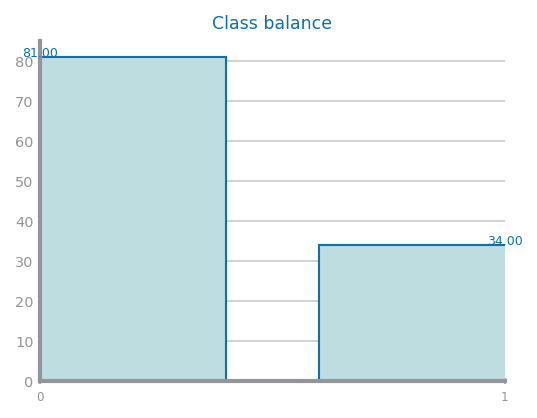

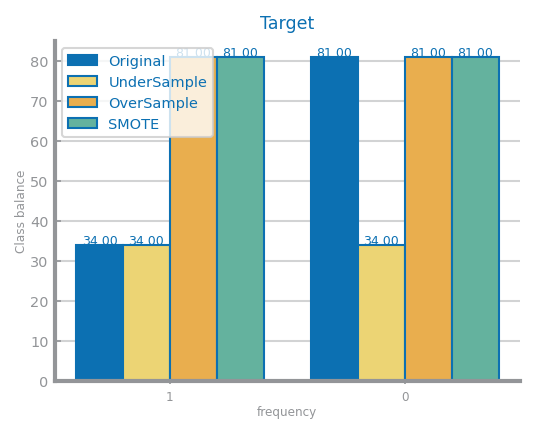

In [84]:
#Data Balancing
filename = 'XAI - Limpo_dummified.csv'
file = "XAI - Limpo"
original = pd.read_csv(filename, sep=',', decimal='.')
class_var = 'surgycal margin'

target_count = original[class_var].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()
#ind_positive_class = target_count.index.get_loc(positive_class)
print('Minority class =', positive_class, ':', target_count[positive_class])
print('Majority class =', negative_class, ':', target_count[negative_class])
print('Proportion:', round(target_count[positive_class] / target_count[negative_class], 2), ': 1')
values = {'Original': [target_count[positive_class], target_count[negative_class]]}

plt.figure()
ds.bar_chart(target_count.index, target_count.values, title='Class balance')
#plt.savefig(f'{file}_balance.png')
plt.show()

#Como a classe minoritária é a positiva o melhor método de balancing deverá ser de "oversampling"
df_positives = original[original[class_var] == positive_class]
df_negatives = original[original[class_var] == negative_class]

#Undersampling - Guarda os resultados positivos e balancei-a a distribuição eliminando resultados negativos.
df_neg_sample = pd.DataFrame(df_negatives.sample(len(df_positives)))
df_under = pd.concat([df_positives, df_neg_sample], axis=0)
df_under.to_csv(f'{name}_under.csv', index='surgycal margin')
values['UnderSample'] = [len(df_positives), len(df_neg_sample)]

#Oversampling - Cria resultados positivos recorrendo aos negativos até se obter o mesmo número de dados.
df_pos_sample = pd.DataFrame(df_positives.sample(len(df_negatives), replace=True))
df_over = pd.concat([df_pos_sample, df_negatives], axis=0)
df_over.to_csv(f'{name}_over.csv', index='surgycal margin')
values['OverSample'] = [len(df_pos_sample), len(df_negatives)]

#SMOTE - Divide os dados originais em 2 e depois gera os resultados positivos sem juntar negativos e positivos, apenas juntar smote_x com smote_y já atulalizado.
RANDOM_STATE = 42
smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
y = original.pop(class_var).values
X = original.values
smote_X, smote_y = smote.fit_resample(X, y)
df_smote = pd.concat([pd.DataFrame(smote_X), pd.DataFrame(smote_y)], axis=1)
df_smote.columns = list(original.columns) + [class_var]
df_smote.to_csv(f'{name}_smote.csv', index='surgycal margin')
smote_target_count = pd.Series(smote_y).value_counts()
values['SMOTE'] = [smote_target_count[positive_class], smote_target_count[negative_class]]

#Plottar os resultados obtidos
plt.figure()
ds.multiple_bar_chart([positive_class, negative_class], values, title='Target', xlabel='frequency', ylabel='Class balance')
plt.show()

array([[<AxesSubplot:title={'center':'Smooth.capsular.bulging'}>,
        <AxesSubplot:title={'center':'Capsular.disruption'}>,
        <AxesSubplot:title={'center':'Unsharp.margin'}>,
        <AxesSubplot:title={'center':'Irregular.contour'}>],
       [<AxesSubplot:title={'center':'Black.estrition.periprostatic.fat'}>,
        <AxesSubplot:title={'center':'Retoprostatic.angle.obliteration'}>,
        <AxesSubplot:title={'center':'Measurable.ECE'}>,
        <AxesSubplot:title={'center':'ECE.in.prostatectomy.specimen_gold.standard'}>],
       [<AxesSubplot:title={'center':'Gleason.score'}>,
        <AxesSubplot:title={'center':'regra'}>,
        <AxesSubplot:title={'center':'Index.lesion.PIRADS.V2_3'}>,
        <AxesSubplot:title={'center':'Index.lesion.PIRADS.V2_4'}>],
       [<AxesSubplot:title={'center':'Index.lesion.PIRADS.V2_5'}>,
        <AxesSubplot:title={'center':'Age.at.MRI'}>,
        <AxesSubplot:title={'center':'Prostate.volume'}>,
        <AxesSubplot:title={'center':'PSA.

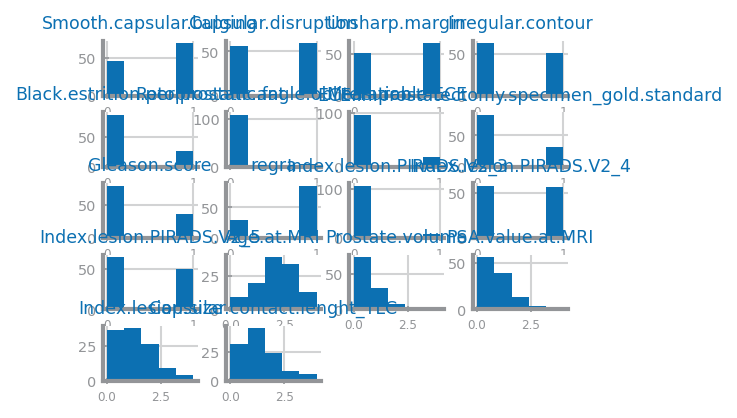

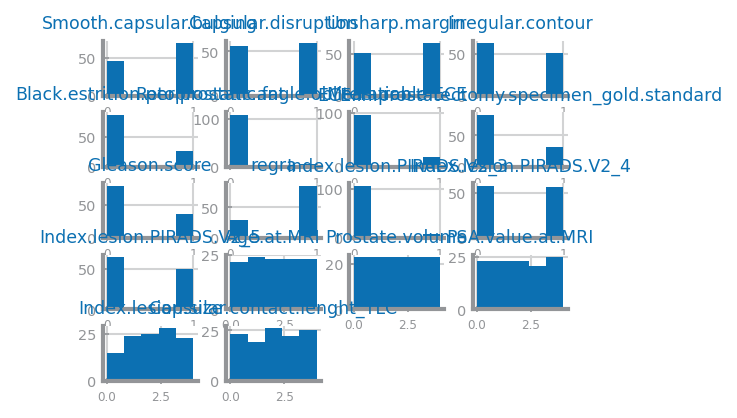

In [89]:
#Discretization - Apenas aplicada para variáveis numéricas.

#Equal-width discretization
N_BINS = 5
discretization = KBinsDiscretizer(n_bins=N_BINS, encode="ordinal", strategy="uniform")
discretization.fit(df_nr)
eq_width = pd.DataFrame(discretization.transform(df_nr), index=data.index)

dfEwd = pd.DataFrame(df_sb, index=data.index)
dfEwd = pd.concat([dfEwd, df_bool, eq_width], axis=1)
dfEwd.columns = symbolic_vars + binary_vars + numeric_vars
dfEwd.to_csv(f'{name}_eq_width.csv', index='surgycal margin')

dfEwd.hist(bins=N_BINS)

#Equal-frequency
discretization = KBinsDiscretizer(n_bins=N_BINS, encode="ordinal", strategy="quantile")
discretization.fit(df_nr)
eq_width = pd.DataFrame(discretization.transform(df_nr), index=data.index)

dfEf = pd.DataFrame(df_sb, index=data.index)
dfEf = pd.concat([dfEf, df_bool, eq_width], axis=1)
dfEf.columns = symbolic_vars + binary_vars + numeric_vars
dfEf.to_csv(f'{name}_eq_frequency.csv', index='surgycal margin')

dfEf.hist(bins=N_BINS)